# Crank–Nicolson method to simulate the Schrödinger equation

### Theory
The Schrödinger equation is given by:

$$ i \hbar \frac{d}{dt} \psi(\vec{r}, t) = \hat{H}\psi(\vec{r}, t) \qquad (1)$$

The initial Gaussian wave packet is described as:

$$ \psi(x,0) = \mathrm{exp} \left(-\frac{(\vec{r}-\vec{r_0})^2}{2w^2} \right) \mathrm{exp} \left(i\vec{k} \cdot \vec{r} \right) \qquad (2)$$

For this simulation we take $\hbar=2m=1$. 
The finite difference approximation of the Schrödinger equation using to the Crank-Nicolson method becomes:

$$ i \frac{\psi(\vec{r},t+\Delta t) - \psi(\vec{r},t)}{\Delta t} = \frac{\hat{H}\psi(\vec{r},t) + \hat{H}\psi(\vec{r},t+\Delta t)} {2} \qquad (3)$$

Which can be rewritten to:

$$ \left[1 + \frac{i\Delta t}{2}\hat{H}\right]\psi(\vec{r},t+\Delta t) = \left[1 - \frac{i\Delta t}{2}\hat{H}\right]\psi(\vec{r},t) \qquad (4)$$

#### 1D case
In the 1D case the Hamiltonian acting on the wave function is given by:

$$ \hat{H}\psi(x,t) = - \frac{\psi(x+\Delta x,t) + \psi(x-\Delta x,t) - 2\psi(x,t)} {\Delta x^2} + V(x)\psi(x,t) \qquad (5)$$

This corresponds to a sparse Hamiltonian. For, e.g., $N_x=5$, the Hamiltonian and wavefunction become: 

$$ H^{1D}=\begin{pmatrix}
-2 & 1 & 0 & 0 & 0\\
1 & -2 & 1 & 0 & 0\\
0 & 1 & -2 & 1 & 0\\
0 & 0 & 1 & -2 & 1\\
0 & 0 & 0 & 1 & -2
\end{pmatrix}, \qquad\qquad \psi^{1D}=\begin{pmatrix}
\psi_1\\
\psi_2\\
\psi_3\\
\psi_4\\
\psi_5
\end{pmatrix} $$


#### 2D case
For the 2D case the Hamiltonian acting on the wavefunction on an equally spaced grid is given by:

$$ \hat{H}\psi(x,t) = - \frac{\psi(x+\Delta x,y,t) + \psi(x-\Delta x,y,t) + \psi(x,y+\Delta y,t) + \psi(x,y+\Delta y,t) - 4\psi(x,y,t)} {\Delta x^2} + V(x,y)\psi(x,y,t) \qquad (6)$$

For $N_x=3$ the Hamiltonian and the wavefunction would look like:

$$ H^{2D}=\begin{pmatrix}
-4 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
1 & -4 & 1 & 0 & 1 & 0 & 0 & 0 & 0\\
0 & 1 & -4 & 0 & 0 & 1 & 0 & 0 & 0\\
1 & 0 & 0 & -4 & 1 & 0 & 1 & 0 & 0\\
0 & 1 & 0 & 1 & -4 & 1 & 0 & 1 & 0\\
0 & 0 & 1 & 0 & 1 & -4 & 0 & 0 & 1\\
0 & 0 & 0 & 1 & 0 & 0 & -4 & 1 & 0\\
0 & 0 & 0 & 0 & 1 & 0 & 1 & -4 & 1\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & -4
\end{pmatrix}, \qquad\qquad \psi^{2D}=\begin{pmatrix}
\psi_{11}\\
\psi_{21}\\
\psi_{31}\\
\psi_{12}\\
\psi_{22}\\
\psi_{32}\\
\psi_{13}\\
\psi_{23}\\
\psi_{33}\\
\end{pmatrix} $$

In [1]:
import numpy as np
import scipy.sparse.linalg
import scipy.sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
%matplotlib notebook

### 1D functions

In [2]:
def Potential(potential):
    # Define the potential V(x) according to a specific configuration given by 'potential'.
    
    V = np.zeros(Nx)
    
    if potential == 'infinite barrier':
        V[int(0.7*Nx):] = 1e10
    
    elif potential == 'infinite well':
        V[0:int(0.4*Nx)] = 1e10
        V[int(0.6*Nx)+1:] = 1e10
        
    elif potential == 'tunneling':
        V[int(0.7*Nx):int(0.8*Nx)] = 1e4
    
    elif potential == 'harmonic oscillator':
        V = 2e5*x**2
    
    else:
        print('Not a compatible potential, V=0')
    
    return V


def simulate(V):
    # Calculate the wave function psi according to the Crank-Nicolson method with Dirichlet boundary conditions.
    
    psi = np.zeros((Nt, Nx), dtype=complex)
    
    # Hamiltonian as a sparse matrix
    H = np.divide(scipy.sparse.diags([1, -2, 1], [-1, 0, 1], shape=(Nx, Nx)).toarray(), dx**2) + np.diag(V)
    I = scipy.sparse.identity(Nx).toarray()
    
    A = (I + np.multiply(H, 1j*dt/2)) # Left hand side matrix in eq. (4)
    
    # Initial Gaussian wave packet
    psi[0] = np.exp(-(x-x0)**2/(2*gaussWidth**2)) * np.exp(1j*x*waveVector)
    psi /= np.trapz(abs(psi[0])**2, dx=dx) # Normalisation
    
    for t in range(Nt-1):
        
        b = (I - np.multiply(H, 1j*dt/2)).dot(psi[t]) # Right hand side in eq. (4)
        
        # Use biconjugate gradient stabilized iteration to solve A*psi = b
        psi[t+1] = scipy.sparse.linalg.bicgstab(A, b.T)[0]
    
    return psi


def animate(t):
    linePsi.set_ydata(abs(psi[t])**2)
    return linePsi,


def init():
    linePsi.set_ydata(np.ma.array(x, mask=True))
    return linePsi,

### 1D Parameters

In [3]:
dx = 0.01 # Spacing between x values
dt = 0.001 # Spacing between time steps

x = np.arange(-1, 1, dx)

Nx = len(x) # Number of spatial steps
Nt = 50 # Number of time steps


font = {'family' : 'serif',
        'size'   : 20}
plt.rc('font', **font)

### 1D Simulation

<IPython.core.display.Javascript object>


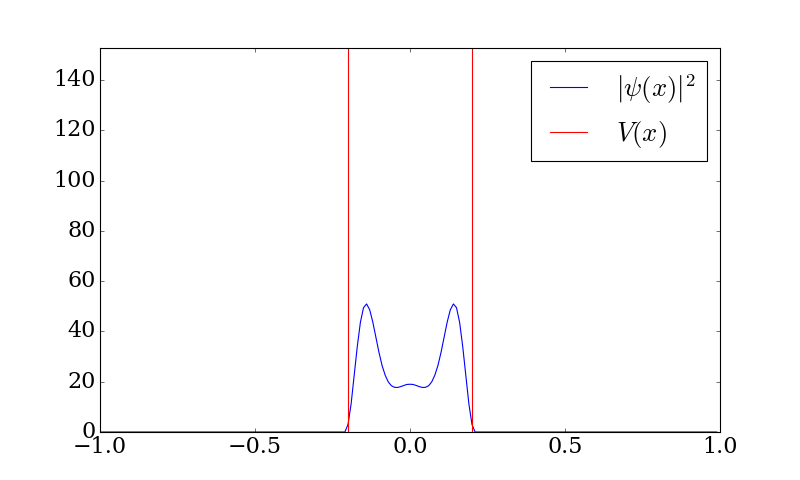

In [4]:
# Choose one of the potentials: infinite well, infinite barrier, tunneling, harmonic oscillator
V = Potential('infinite well')

# Parameters for the initial gaussian wave packet at t=0
gaussWidth = 0.05
waveVector = 0
x0 = 0 # Initial position

psi = simulate(V)

# Plot the result
fig, ax = plt.subplots(figsize=(10, 6))
linePsi, = ax.plot(x, abs(psi[0, :])**2, label='$|\psi(x)|^2$')
plt.plot(x, V, c='r', label='$V(x)$')
plt.ylim(0, 1.2*max(abs(psi[0])**2))
plt.legend(loc=0)
ani = animation.FuncAnimation(fig, animate, frames=Nt, init_func=init, interval=100, blit=True)

plt.show()

## Schrödinger equation in 2 dimension

### 2D functions

In [5]:
def potential2D(potential):
    # Define the potential V(x,y) according to a specific configuration given by 'potential'.
    
    V2D = np.zeros((Nx, Nx))
    
    if potential == 'infinite barrier':
        V2D[:, int(0.7*Nx):] = 1e10
    
    elif potential == 'double slit':
        V2D[:int(0.3*Nx),            int(0.60*Nx):int(0.65*Nx)] = 1e10
        V2D[int(0.4*Nx):int(0.6*Nx), int(0.60*Nx):int(0.65*Nx)] = 1e10
        V2D[int(0.7*Nx):,            int(0.60*Nx):int(0.65*Nx)] = 1e10
    
    elif potential == 'tunneling':
        V2D[:, int(0.6*Nx):int(0.65*Nx)] = 1e3
    
    elif potential == 'harmonic oscillator':
        V2D = 2e5*(xx**2+yy**2)
    
    else:
        print('Not a compatible potential, V=0')
    
    return V2D


def simulation2D(V2D):
    # Calculate the wave function psi according to the Crank-Nicolson method with Dirichlet boundary conditions.
    
    psi2D = np.zeros((Nt, Nx, Nx), dtype=complex)
    
    # 1D Hamiltonian as a sparse matrix
    H = np.divide(scipy.sparse.diags([1, -2, 1], [-1, 0, 1], shape=(Nx, Nx)).toarray(), dx**2)
    
    I = scipy.sparse.identity(Nx).toarray()
    I2 = scipy.sparse.identity(Nx**2).toarray()
    
    H2D = np.kron(H, I) + np.kron(I, H) + np.diag(V2D.reshape((-1), order='F')) # 2D Hamiltonian
    
    A = (I2 + np.multiply(H2D, 1j*dt/2)) # Left hand side matrix in eq. (4)
    
    # Initial Gaussian wave packet
    psi2D[0] = np.exp(-(xx - x0)**2/(2*gaussWidthX**2) - (yy-  y0)**2/(2*gaussWidthY**2)) * np.exp(1j*(xx*waveVectorX 
                                                                                                       + yy*waveVectorY))
    psi2D[0] /= np.trapz(np.trapz(abs(psi2D[0])**2, dx=dx), dx=dx) # Normalisation
    
    psi2D = psi2D.reshape((Nt, -1), order='F')
    
    for t in range(Nt-1):
    
        b = (I2 - np.multiply(H2D, 1j*dt/2)).dot(psi2D[t]) # Right hand side in eq. (4)
        
        psi2D[t+1] = scipy.sparse.linalg.bicgstab(A, b.T)[0] # Use biconjugate gradient stabilized iteration to solve A*psi = b
    
    
    psi2D = psi2D.reshape((Nt, Nx, Nx), order='F')
    
    return psi2D


def animate2D(t):
    im = ax.contourf(xx, yy, abs(psi2D[t])**2, cmap=cm.gray)
    return im,


### 2D Parameters

In [6]:
dx = 0.05 # Spacing between x values
dt = 0.001 # Spacing between time steps

x = np.arange(-1, 1, dx)
xx, yy = np.meshgrid(x, x)

Nx = len(x) # Number of spatial steps
Nt = 50 # Number of time steps


font = {'family' : 'serif',
        'size'   : 20}
plt.rc('font', **font)

## 2D simulation

<IPython.core.display.Javascript object>


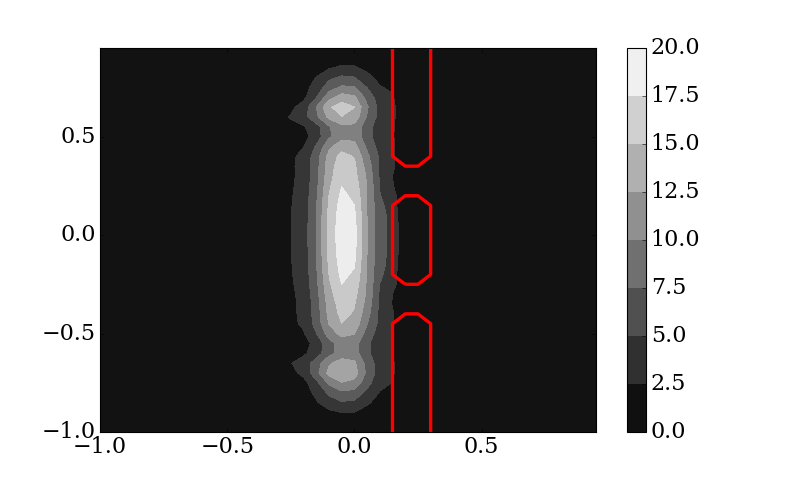

In [7]:
# Choose one of the potentials: infinite barrier, double slit, tunneling, harmonic oscillator
V2D = potential2D('double slit')

# Parameters for the initial gaussian wave packet at t=0
gaussWidthX = 0.1
gaussWidthY = 0.8
waveVectorX = -20
waveVectorY = 0
x0 = -0.5 # Initial x-position
y0 = 0 # Initial y-position

psi2D = simulation2D(V2D)

fig = plt.figure(figsize=(10, 6))
im = plt.contourf(xx, yy, abs(psi2D[0])**2, cmap=cm.gray)
plt.contour(x, x, V2D, levels=[0], linewidths=3, colors='red')
ax = fig.gca()
plt.colorbar(im)

ani = animation.FuncAnimation(fig, animate2D, frames=Nt, interval=20, blit=True)
